#Bibliotecas

In [27]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, classification_report
)
from datetime import datetime

In [28]:
#%% Inicio
start_datetime = datetime.now()
print('start: ' + str(start_datetime))

start: 2025-10-26 20:57:41.036638


#1. Lectura de datos

In [16]:
df_credit = pd.read_csv(
    r'/content/credito.txt',
    low_memory=False,
    sep="\t"
)
df_credit.head()

,A1,A2,A3,A8,A9,A10,A11,A12,A14,A15,R1
0,1,30.83,0.000,1.25,1,0,1,1,202,0,1
1,0,58.67,4.460,3.04,1,0,6,1,43,560,1
2,0,24.50,0.500,1.50,1,1,0,1,280,824,1
3,1,27.83,1.540,3.75,1,0,5,0,100,3,1
4,1,20.17,5.625,1.71,1,1,0,1,120,0,1


###Analisis exploratorio

In [17]:
df_credit.describe()

,A1,A2,A3,A8,A9,A10,A11,A12,A14,A15,R1
count,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000
mean,0.689602,31.578349,4.830558,2.241690,0.535168,0.561162,2.498471,0.538226,180.084098,1012.730887,0.452599
std,0.463010,11.981789,5.023295,3.369197,0.499143,0.496625,4.965655,0.498918,168.315719,5249.320660,0.498129
min,0.000000,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.580000,1.040000,0.165000,0.000000,0.000000,0.000000,0.000000,70.750000,0.000000,0.000000
50%,1.000000,28.460000,2.855000,1.000000,1.000000,1.000000,0.000000,1.000000,160.000000,5.000000,0.000000
75%,1.000000,38.250000,7.437500,2.615000,1.000000,1.000000,3.000000,1.000000,271.000000,399.000000,1.000000
max,1.000000,80.250000,28.000000,28.500000,1.000000,1.000000,67.000000,1.000000,2000.000000,100000.000000,1.000000


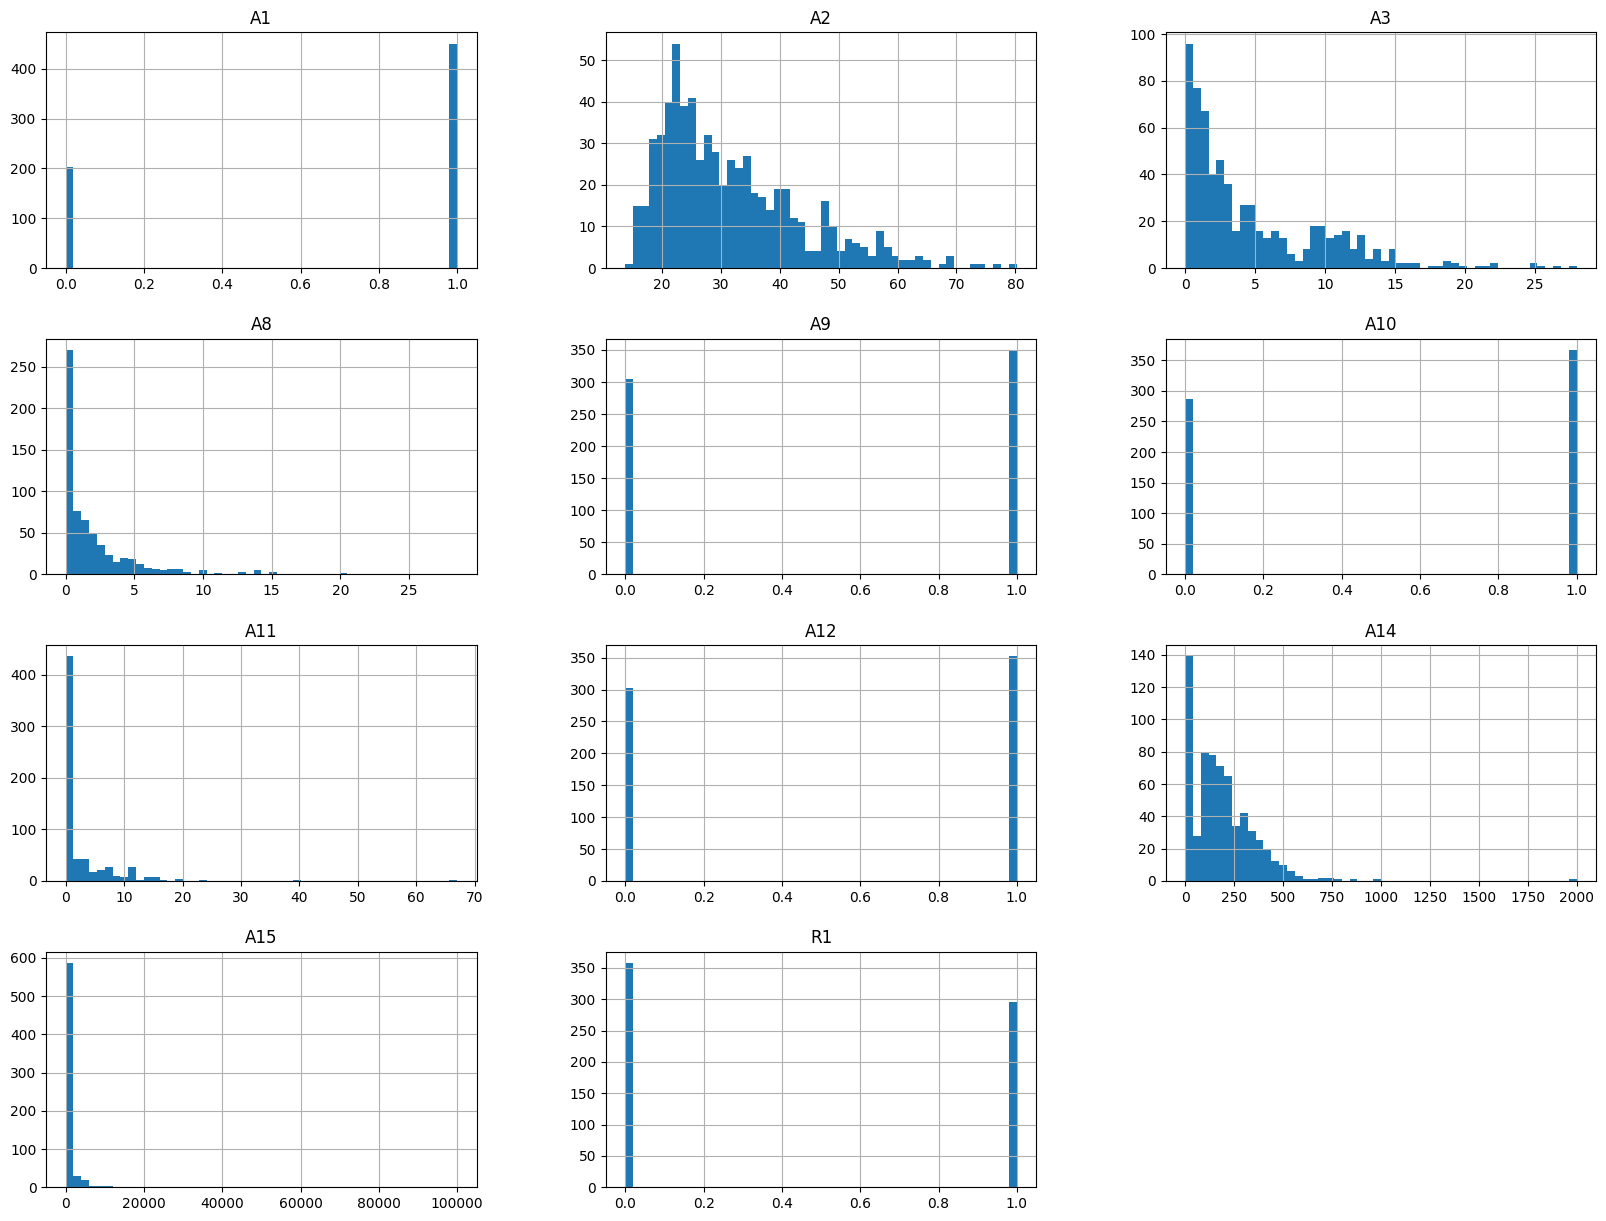

In [18]:
import matplotlib.pyplot as plt
df_credit.hist(bins=50, figsize=(20,15))
plt.show()

In [19]:
df_credit.isnull().sum()


,0
A1,0
A2,0
A3,0
A8,0
A9,0
A10,0
A11,0
A12,0
A14,0
A15,0


#Variables y target

In [22]:
y = df_credit['R1'].astype(int)
X = df_credit.drop('R1', axis=1)


###comprobar balanceo

In [23]:
y.value_counts(normalize=True)

,proportion
R1,
0,0.547401
1,0.452599


#Conjunto de prueba



In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


##Tipos de datos

In [5]:
card = X_train.nunique()
binary_cols = [c for c in X_train.columns if card[c] == 2]
continuous_cols = [c for c in X_train.columns if card[c] > 2]

print("Binarias:", binary_cols)
print("Continuas:", continuous_cols)


Binarias: ['A1', 'A9', 'A10', 'A12']
Continuas: ['A2', 'A3', 'A8', 'A11', 'A14', 'A15']


#Preprocesamiento utilizando pipelines

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, continuous_cols),
        ('bin', binary_transformer, binary_cols)
    ]
)


#Regresión logistica

##Entrenamiento Regresion logisca

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Construimos el pipeline completo (preprocesamiento + modelo)
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=200, solver='lbfgs'))
])

# Definimos una pequeña grilla de búsqueda
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__class_weight': [None, 'balanced']
}

# Búsqueda con validación cruzada
grid = GridSearchCV(
    pipe,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
best_model = grid.best_estimator_


Mejores parámetros: {'clf__C': 10.0, 'clf__class_weight': 'balanced'}


##Evaluacion regresion logistica

Accuracy: 0.8780487804878049
Precision: 0.7934782608695652
Recall: 0.9864864864864865
F1: 0.8795180722891566
ROC-AUC: 0.9533033033033034

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88        90
           1       0.79      0.99      0.88        74

    accuracy                           0.88       164
   macro avg       0.89      0.89      0.88       164
weighted avg       0.90      0.88      0.88       164


Matriz de Confusión:
[[71 19]
 [ 1 73]]


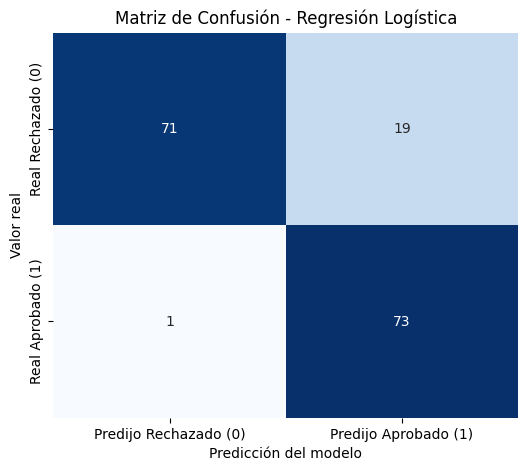

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
)

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))


# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear el gráfico
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predijo Rechazado (0)', 'Predijo Aprobado (1)'],
            yticklabels=['Real Rechazado (0)', 'Real Aprobado (1)'])
plt.xlabel('Predicción del modelo')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()



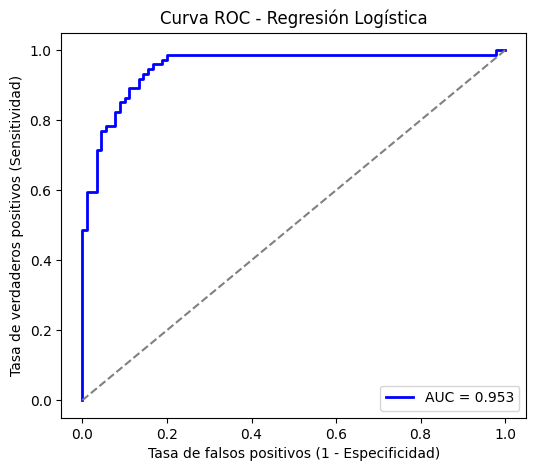

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc:.3f}')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('Tasa de falsos positivos (1 - Especificidad)')
plt.ylabel('Tasa de verdaderos positivos (Sensitividad)')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()


# Random Forest

###Entrenamiento

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Pipeline: preprocesamiento + Random Forest
pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

# Búsqueda de hiperparámetros básicos
param_grid_rf = {
    'clf__n_estimators': [200, 500],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_leaf': [1, 2, 5],
    'clf__class_weight': [None, 'balanced']
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Mejores parámetros:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_


Mejores parámetros: {'clf__class_weight': 'balanced', 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}


##Evaluar random forest

Accuracy: 0.8597560975609756
Precision: 0.8072289156626506
Recall: 0.9054054054054054
F1: 0.8535031847133758
ROC-AUC: 0.9563063063063063

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.91      0.82      0.87        90
           1       0.81      0.91      0.85        74

    accuracy                           0.86       164
   macro avg       0.86      0.86      0.86       164
weighted avg       0.87      0.86      0.86       164



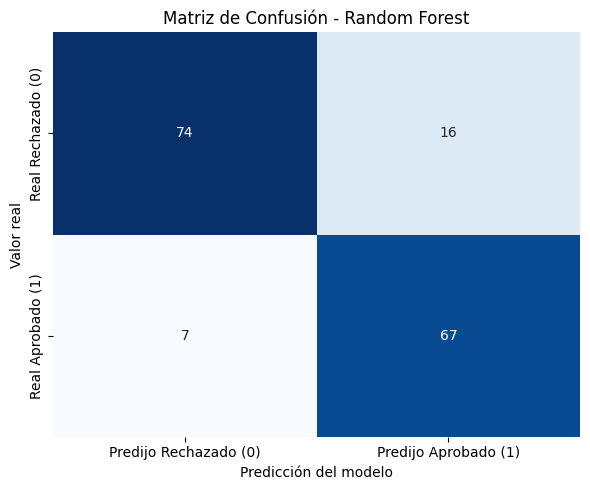

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones y probabilidades con Random Forest
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred_rf))

# Matriz de confusión (usar y_pred_rf)
cm = confusion_matrix(y_test, y_pred_rf)

# Gráfico
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predijo Rechazado (0)', 'Predijo Aprobado (1)'],
            yticklabels=['Real Rechazado (0)', 'Real Aprobado (1)'])
plt.xlabel('Predicción del modelo')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión - Random Forest')
plt.tight_layout()
plt.show()



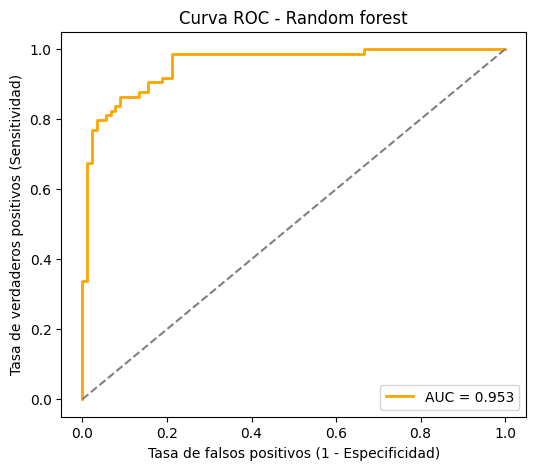

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'AUC = {auc:.3f}')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('Tasa de falsos positivos (1 - Especificidad)')
plt.ylabel('Tasa de verdaderos positivos (Sensitividad)')
plt.title('Curva ROC - Random forest')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

#Respuestas test

a. Mencione las razones por las que eligió dicho algoritmo y explique los resultados de clasificación obtenidos al correr su algoritmo (en R o Python)
con la base de datos suministrada.

Después de evaluar y comparar ambos algoritmos, se observa que el Random Forest presenta un AUC ligeramente más alto, lo que indica mayor precisión y capacidad de discriminación entre las solicitudes aceptadas y rechazadas.

Además, el modelo se encuentra bien calibrado y se adapta mejor al tipo de datos del problema, ya que el Random Forest tiene la ventaja de detectar patrones más complejos entre las variables.
Esto se debe a que combina múltiples árboles de decisión, lo que le permite capturar relaciones no lineales, manejar diferentes tipos de variables y reducir el riesgo de errores o sobreajuste.

En resumen, el Random Forest logra un mejor equilibrio entre precisión, estabilidad y capacidad de generalización, por lo que resulta ser el clasificador más adecuado para este conjunto de datos.

b.Calcule la precisión, sensitividad y especificidad e interprételas para evaluar el desempeño de su
clasificador.

Interpretación de las métricas

Precisión (Accuracy = 0.86):
Ambos modelos aciertan aproximadamente en el 86 % de las predicciones totales, lo que demuestra un buen desempeño general.

Sensitividad (Recall ≈ 0.91):
El modelo detecta correctamente el 91 % de las solicitudes que realmente fueron aprobadas (clase 1).
Esto significa que comete pocos falsos negativos, lo que es importante para no rechazar clientes confiables.

Especificidad (clase 0 = 0.82 en Random Forest):
El modelo identifica correctamente el 82 % de los clientes que deben ser rechazados, evitando aprobar solicitudes de alto riesgo.

Precisión (Precision ≈ 0.81):
De todas las solicitudes que el modelo predijo como “aprobadas”, el 81 % fueron realmente aprobadas.
En otras palabras, el modelo tiene buena capacidad para distinguir entre clientes buenos y malos.

AUC (0.956):
El Random Forest presenta un ligero aumento en el AUC respecto a la regresión logística (0.953), lo que indica mejor capacidad para diferenciar entre ambas clases (aceptados y rechazados).



c. Obtenga la gráfica ROC e interprétela para evaluar el desempeño de su clasificador.


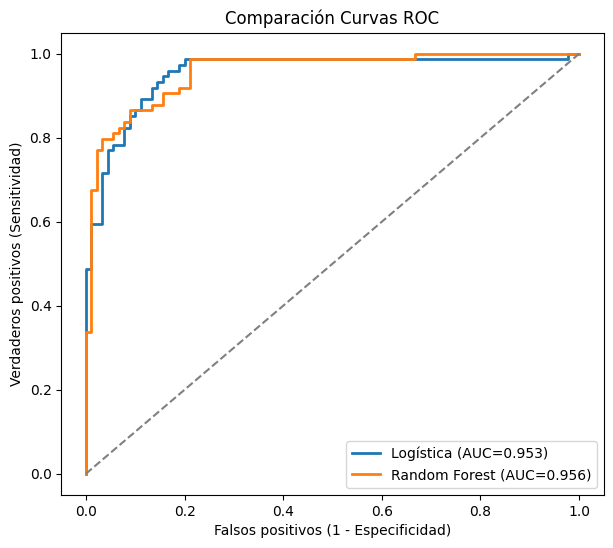

In [31]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(7,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logística (AUC={roc_auc_score(y_test, y_prob):.3f})', lw=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, y_prob_rf):.3f})', lw=2)
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('Falsos positivos (1 - Especificidad)')
plt.ylabel('Verdaderos positivos (Sensitividad)')
plt.title('Comparación Curvas ROC')
plt.legend()
plt.grid(False)
plt.show()